# Basic Statistics on TMS Postings

This notebook uses a csv file containing the composite of recordings from the TMS. Recordings began on 2/21/17 and were last done on 3/11/17. A few postings were removed from the TMS before 2/21/17, but the vast majority of positions available to 2017 PMF finalists were recorded. The contents of each individual posting are not within this csv file, only some data universal to each posting (hiring agency, starting date, number of positions, location, etc.). 

In [1]:
import pandas as pd #to write/read/work with csv files.
import numpy as np #to do math
import matplotlib.pyplot as plt #To make plots
import seaborn as sns #for additional plot features
%matplotlib inline
from datetime import timedelta #for accurate plotting of dates%matplotlib inline
from datetime import datetime

Opening csv file into a pandas dataframe, labeled df2 for historical reasons

In [2]:
df2=pd.read_csv('meta_composite.csv',encoding='ISO-8859-1')
date_of_last_scrape='03/20/2017'
a=date_of_last_scrape.split('/')
date=a[2][-2:]+a[0]+a[1]

A brief check at the first and last jobs in the composite of TMS postings to make sure everything looks good.

In [3]:
df2.head(2)

,Listings,Position Title,Agency/Sub-Agency,Opening Date,Closing Date,Number of Positions,State,Series,GS-09,GS-11,GS-12,GS-13,Promotion Potential
0,3,Research Analyst,Broadcasting Board of Governors,1/13/2017,12/13/2017,1,DC,343,False,True,False,False,GS-13
1,9,Management and Program Analyst,Department of the Treasury / Bureau of the Fis...,1/18/2017,3/1/2017,1,DC,343,False,True,True,False,GS-12


In [4]:
df2.tail(2)

,Listings,Position Title,Agency/Sub-Agency,Opening Date,Closing Date,Number of Positions,State,Series,GS-09,GS-11,GS-12,GS-13,Promotion Potential
301,337,Writer/Editor,Department of Veterans Affairs / Veterans Heal...,3/20/2017,3/24/2017,1,NC,1082,False,True,False,False,GS-12
302,339,Natural Resources Specialist,Department of Agriculture / Natural Resources ...,3/20/2017,3/24/2017,1,DC,401,True,False,False,False,GS-12


The first question would be how many positions have been offered to PMFs over the recorded time period:

In [5]:
df2['Number of Positions'].sum()

665

Many postings have multiple positions (e.g. posting 0308 is for 36 "Acquisition Program Management Specialists"). The second question may be how many postings have been offered to PMFs over the recorded time period:

In [6]:
len(df2.Listings.value_counts().index)

261

Some postings are broken onto multiple rows of the dataframe df2. This was done for postings in multiple locations, to give each location it's own row. As a consequence, a bit of care is needed to only count unique postings.

In [7]:
len(df2)

303

On average, each posting has several positions. However the distribution isn't even. A relatively small subset of the postings account for the majority of the positions, as can be seen here:

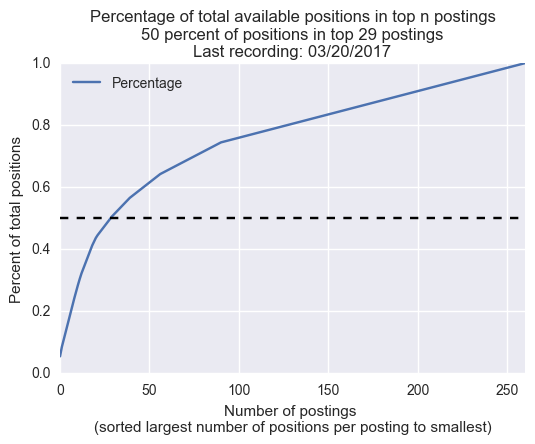

In [8]:
a=list(df2.loc[:,'Listings'].value_counts().index.values)
a.sort()
df_temp=pd.DataFrame();
df_temp['Listings']=a
#below, combining rows for same posting but different locations to get total positions for each posting
x=0
for elm in a:
    df_temp.loc[x,'Number of Openings']=df2.loc[df2.loc[:,'Listings']==elm,'Number of Positions'].sum()
    x=x+1
#now sort by highest number of positions in posting
b=df_temp.sort_values('Number of Openings', ascending=False)
#calculating the percent of total positions represented by top n sorted postings
b['Percentage']=0
b.reset_index(inplace=True)
del b['index']
for x in range(0,len(b)):
    b.loc[x,'Percentage']=b.loc[0:x,'Number of Openings'].sum()/(df2.loc[:,'Number of Positions'].sum())
#and finally plot the results
b.plot(y='Percentage');
plt.ylabel('Percent of total positions');
plt.xlabel('Number of postings \n(sorted largest number of positions per posting to smallest)');
plt.title('''Percentage of total available positions in top n postings
50 percent of positions in top %s postings
Last recording: %s'''%(b.loc[b.loc[:,'Percentage']>.5,:].index[0],date_of_last_scrape));
plt.axhline(.5,color='black',linestyle='--');
#%(date_of_last_scrape)
#C:\Users\Kyle\Documents\Blog Posts\PMF\PMF_graphs\PMF_GitHub\

Counting the available positions by various descriptors (position title, agency, etc.) can give some insight into what positions are most common and which agencies are hiring the most.

val==column name

min_count==way to limit how many different values shown in plot

The same block of code with different values for val and min_count is repeated several times below.

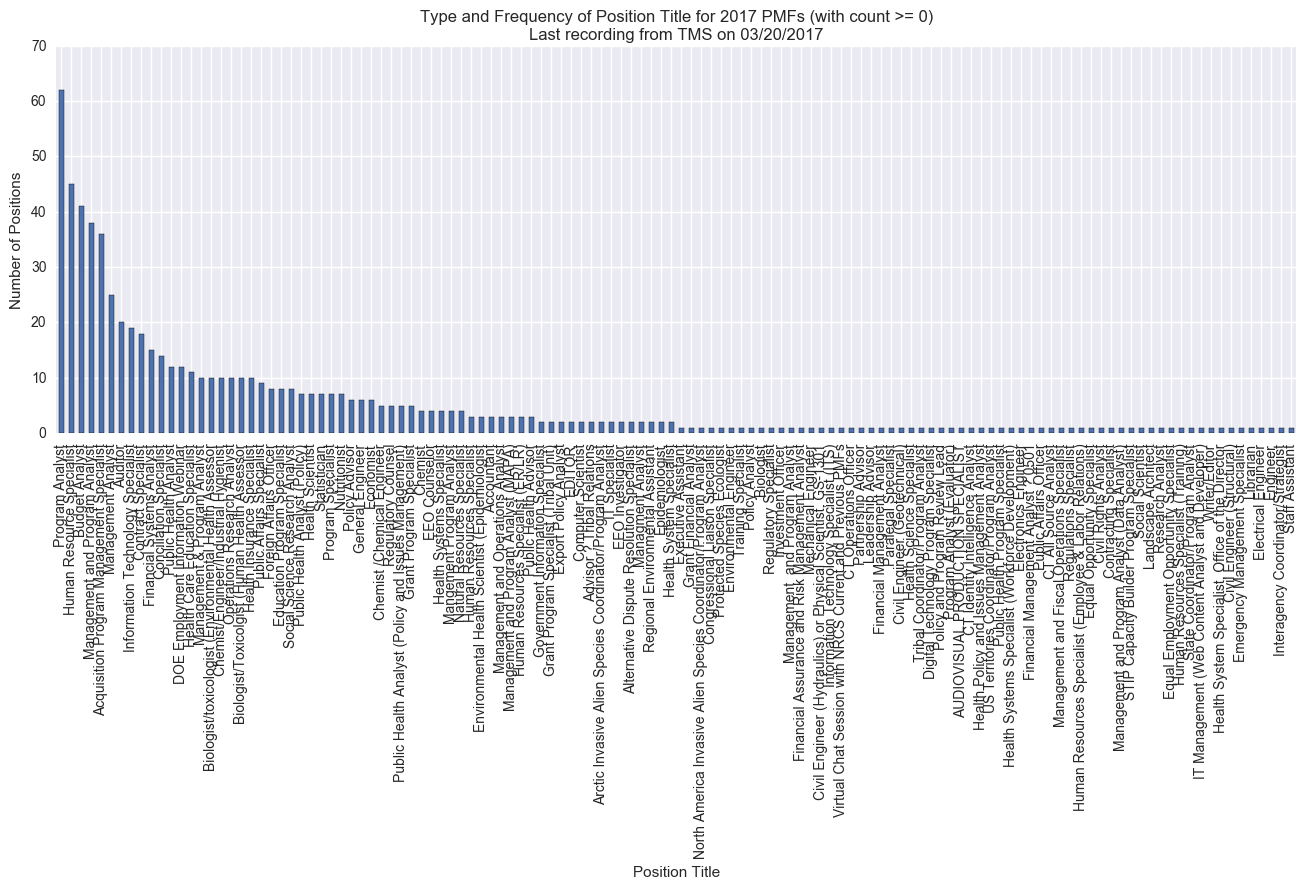

In [9]:
val='Position Title'
min_count=0;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

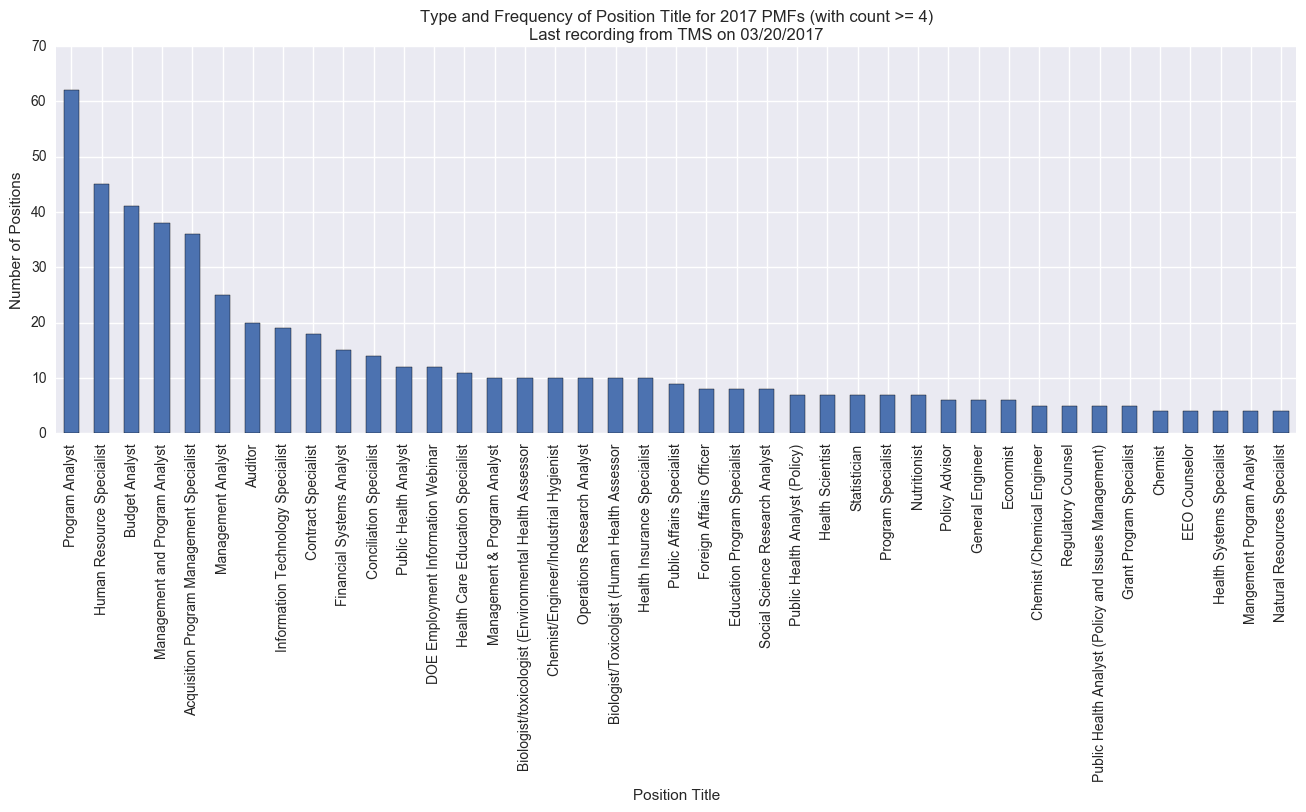

In [10]:
val='Position Title'
min_count=4;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

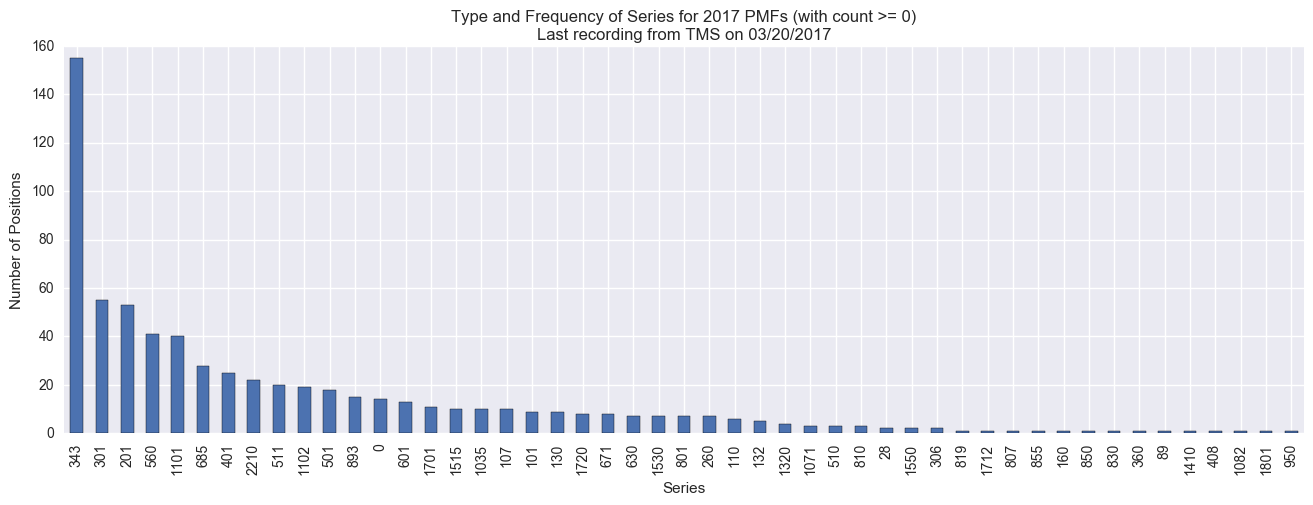

In [11]:
val='Series'
min_count=0;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

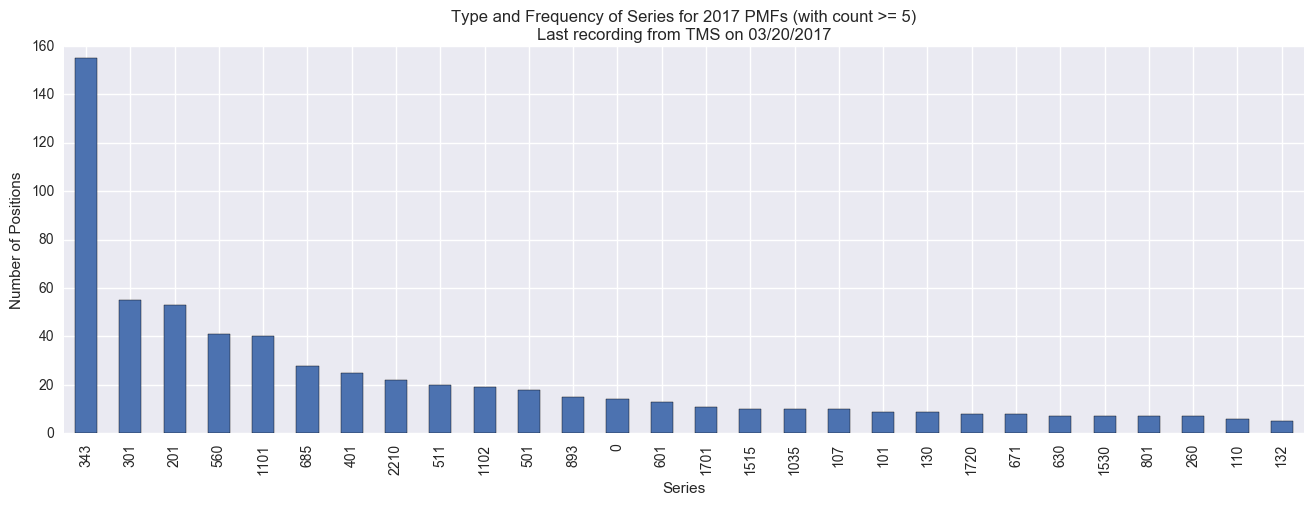

In [12]:
val='Series'
min_count=5;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

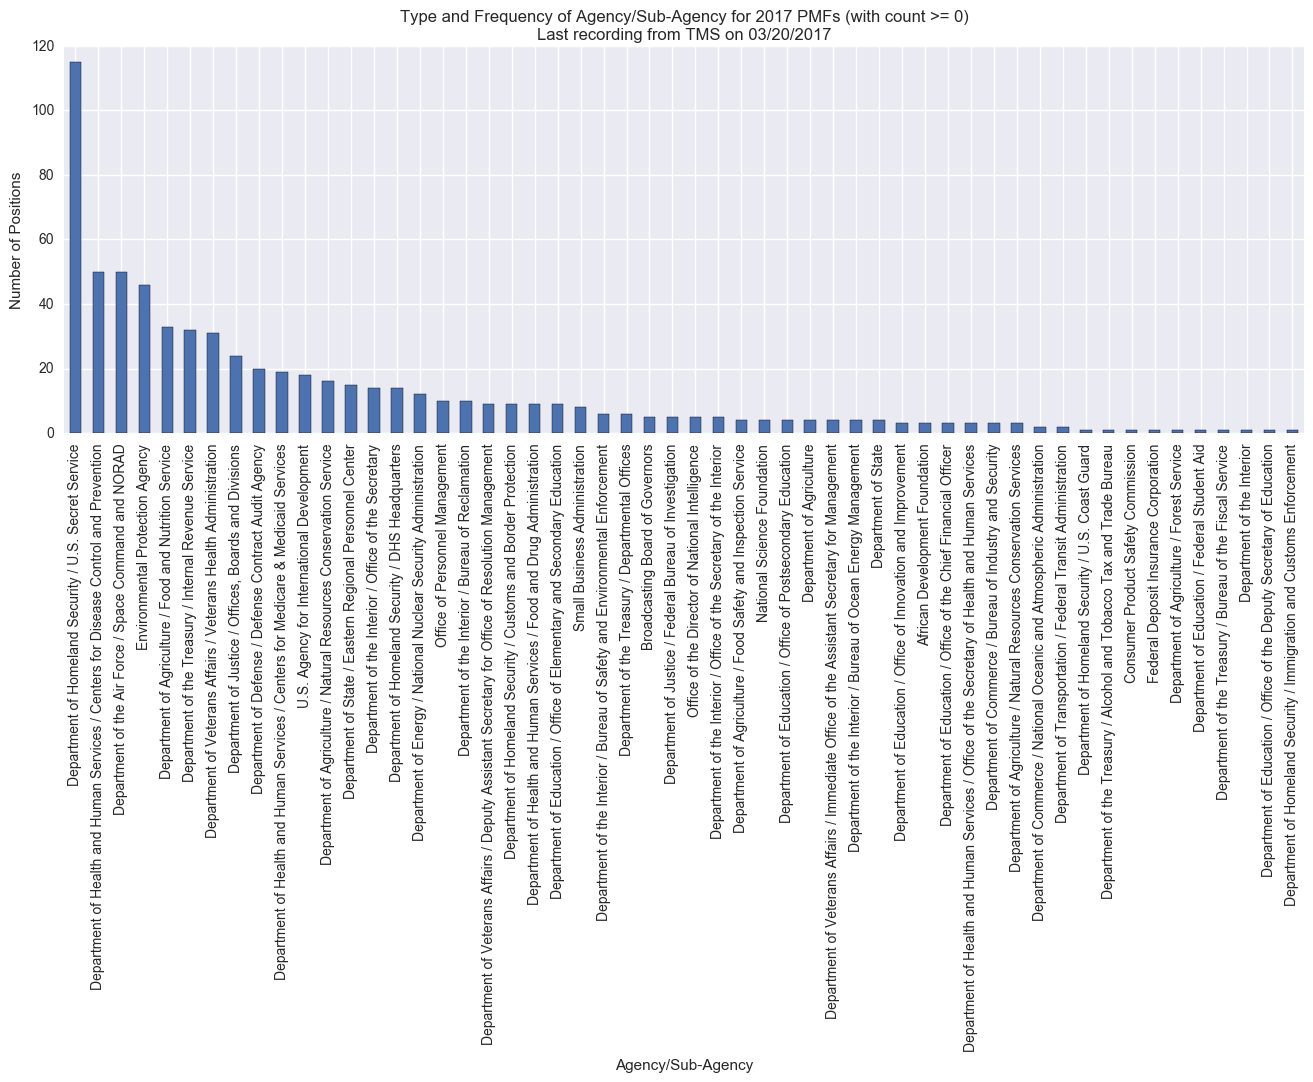

In [13]:
val='Agency/Sub-Agency'
min_count=0;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

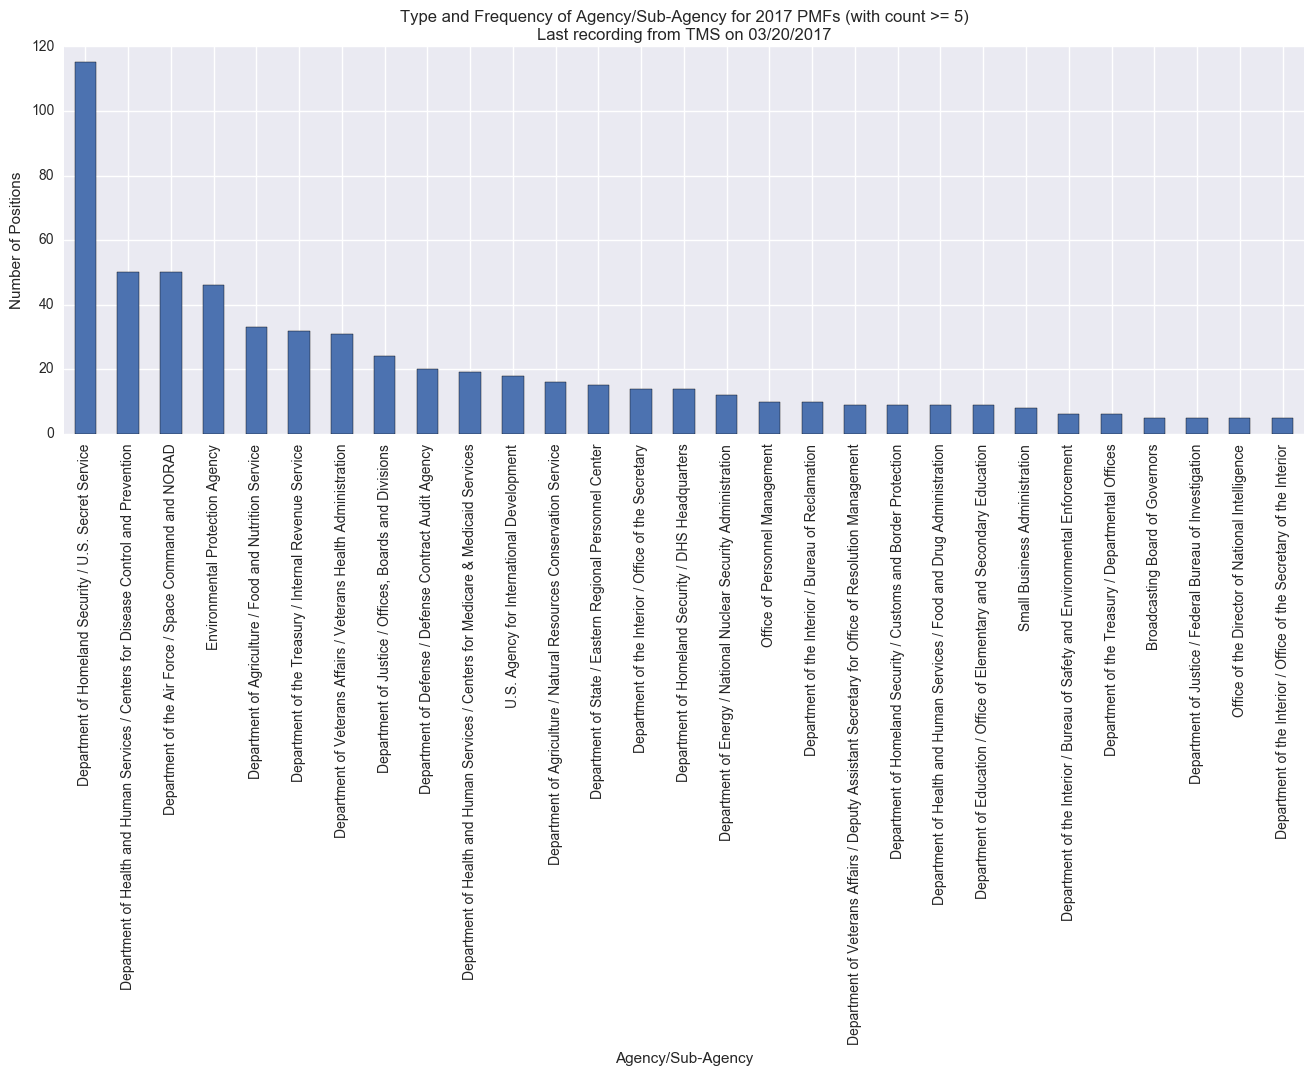

In [14]:
val='Agency/Sub-Agency'
min_count=5;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

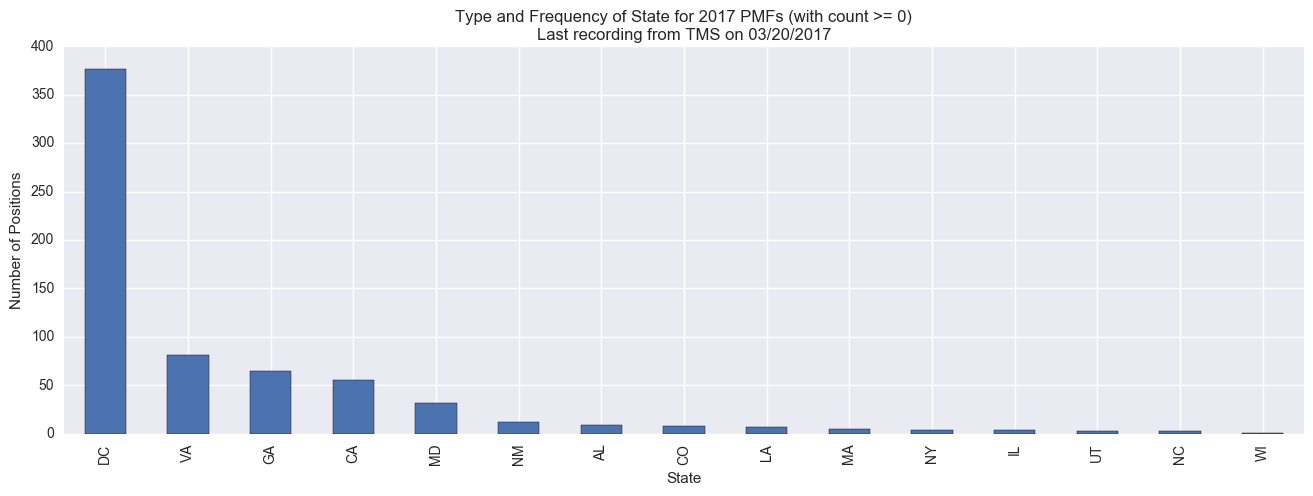

In [15]:
val='State'
min_count=0;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

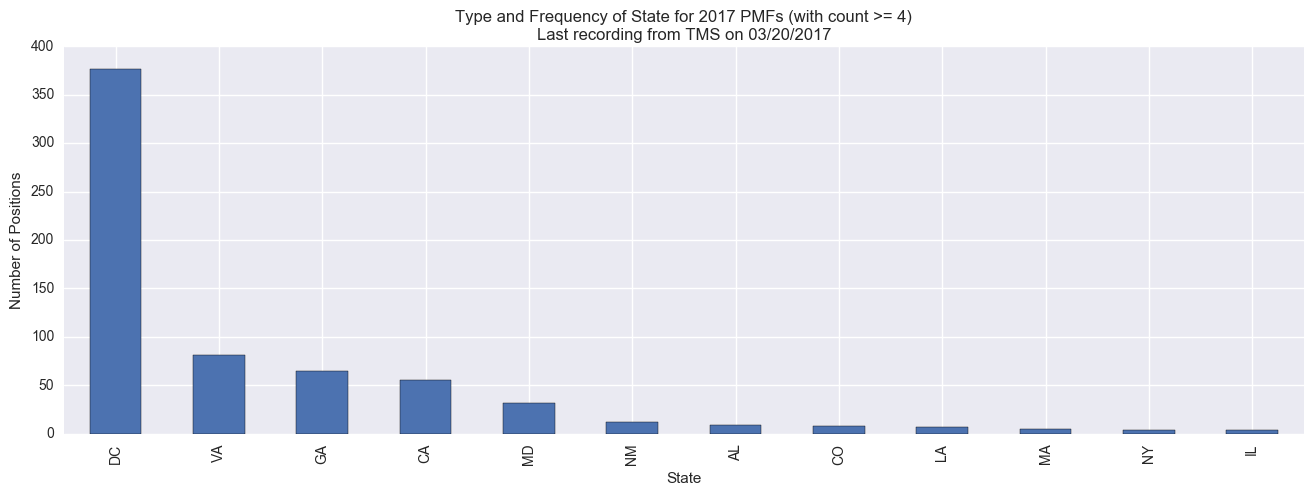

In [16]:
val='State'
min_count=4;
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
df_titleTypes=df_titleTypes.loc[df_titleTypes.loc[:,'Count']>=min_count,:]
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs (with count >= %s)\nLast recording from TMS on %s'%(
        val, min_count,date_of_last_scrape));

A differnt bit of code looks at the opening and closing dates every day to determine how many positions are available on any given day.

Also looks for which agency and which job title is most common on any day.

In [17]:
df2['Opening Date']=pd.to_datetime(df2['Opening Date'])
df2['Closing Date']=pd.to_datetime(df2['Closing Date'])
df2['Opening Date 2']=df2.loc[:,'Opening Date']-pd.Timestamp('20170101')
df2['Closing Date 2']=df2.loc[:,'Closing Date']-pd.Timestamp('20170101')

In [18]:
#number available
df_time=pd.DataFrame()
df_time['Days']=range(0,150)
df_time['Positions']=0
df_time['Top Agency']=''
df_time['Top Title']=''

In [19]:
for x in range(0,len(df_time)):
    df_time.loc[x,'Positions']=df2.loc[(df2.loc[:,'Opening Date 2'].dt.days<=x)&(
        df2.loc[:,'Closing Date 2'].dt.days>=x),'Number of Positions'].sum()
    try:
        df_time.loc[x,'Top Agency']=df2.loc[(df2.loc[:,'Opening Date 2'].dt.days<=x)&(
            df2.loc[:,'Closing Date 2'].dt.days>=x),
        ['Agency/Sub-Agency','Number of Positions']].groupby(
    'Agency/Sub-Agency').sum().sort_values('Number of Positions',ascending=False).index[0]
    except:
        pass
    try:
        df_time.loc[x,'Top Title']=df2.loc[(df2.loc[:,'Opening Date 2'].dt.days<=x)&(
            df2.loc[:,'Closing Date 2'].dt.days>=x),
        ['Position Title','Number of Positions']].groupby(
    'Position Title').sum().sort_values('Number of Positions',ascending=False).index[0]
    except:
        pass

In [20]:
for x in range(0,len(df_time)):
    df_time.loc[x,'Date']=pd.Timestamp('20170101')+timedelta(days=x)

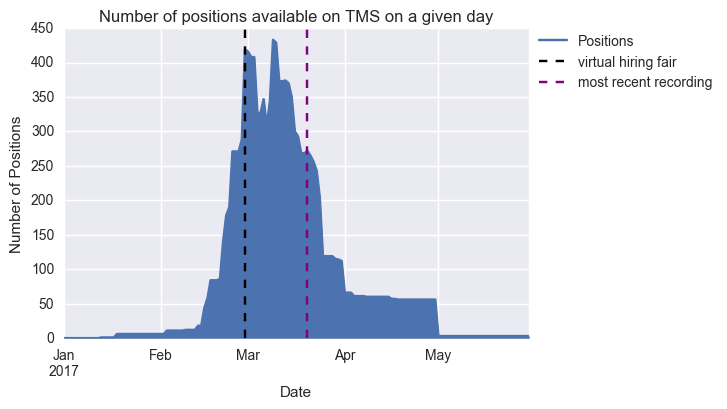

In [21]:
df_time.plot.area(x='Date',y='Positions');
plt.ylabel('Number of Positions');
plt.xlabel('Date');
plt.title('Number of positions available on TMS on a given day');
plt.axvline(pd.Timestamp('20170228'),color='black',linestyle='--',label='virtual hiring fair');
plt.axvline(pd.Timestamp('20'+date),color='purple',linestyle='--',label='most recent recording');
plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);
plt.savefig('C:/Users/Kyle/Documents/Blog Posts/PMF/PMF_graphs/PMF_GitHub/Percentage%s.png'%(date))

Can do the same thing for the number of postings on the TMS each day, by removing duplicate rows for the same job number (note: this can accurately count number of postings on TMS but loses information on number of positions and locations available). Making a special dataframe so I don't lose information from df2.

In [22]:
df3=df2.copy()
df3=df3.drop_duplicates(subset='Listings')
df3.reset_index(inplace=True)
del df3['index']

In [23]:
df_time2=pd.DataFrame()
df_time2['Days']=range(0,150)
df_time2['Postings']=0
for x in range(0,len(df_time2)):
    df_time2.loc[x,'Postings']=len(df3.loc[(df3.loc[:,'Opening Date 2'].dt.days<=x)&(
        df3.loc[:,'Closing Date 2'].dt.days>=x),:])
from datetime import timedelta
for x in range(0,len(df_time2)):
    df_time2.loc[x,'Date']=pd.Timestamp('20170101')+timedelta(days=x)

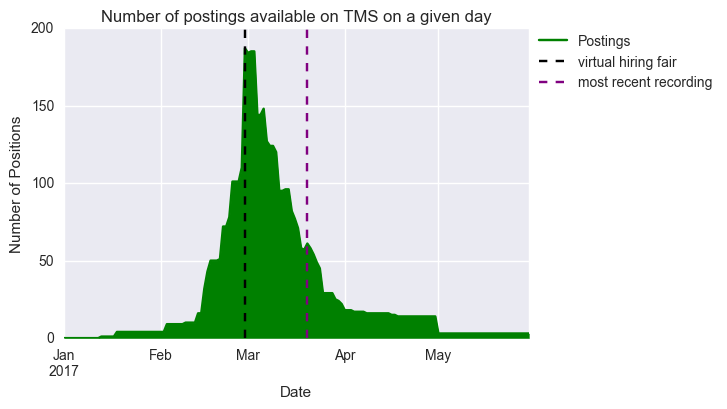

In [24]:
df_time2.plot.area(x='Date',y='Postings',color='green');
plt.ylabel('Number of Positions');
plt.xlabel('Date');
plt.title('Number of postings available on TMS on a given day');
plt.axvline(pd.Timestamp('20170228'),color='black',linestyle='--',label='virtual hiring fair');
plt.axvline(pd.Timestamp('20'+date),color='purple',linestyle='--',label='most recent recording');
plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);

In [25]:
df_time2[df_time2['Date']=='2017-03-20']

,Days,Postings,Date
78,78,61,2017-03-20


And combine the two graphs from above to get a better feel for how opportunities vary with time.

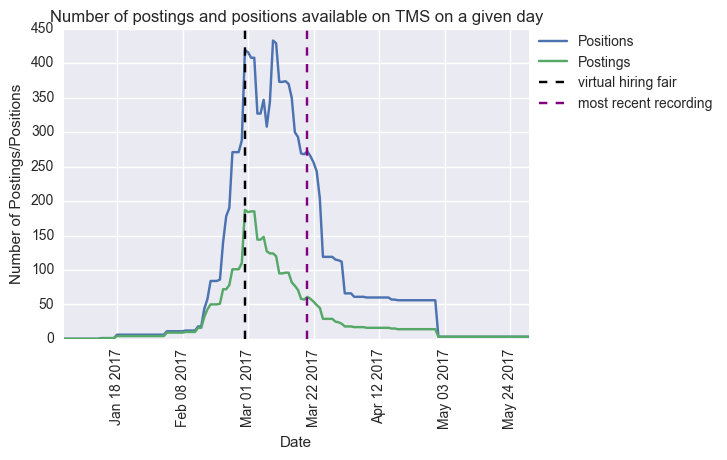

In [26]:
plt.plot(df_time['Date'],df_time['Positions'],label='Positions')
plt.plot(df_time2['Date'],df_time2['Postings'],label='Postings')
plt.ylabel('Number of Postings/Positions');
plt.xlabel('Date');
plt.legend(loc=2);
plt.title('''Number of postings and positions available on TMS on a given day''');
plt.axvline(pd.Timestamp('20170228'),color='black',linestyle='--',label='virtual hiring fair');
plt.axvline(pd.Timestamp('20'+date),color='purple',linestyle='--',label='most recent recording');
plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);
plt.xticks(rotation=90);

Below: incorrect plots! df_time counting frequency of title and agency in dataframe. Not accounting for number of positions in each posting!

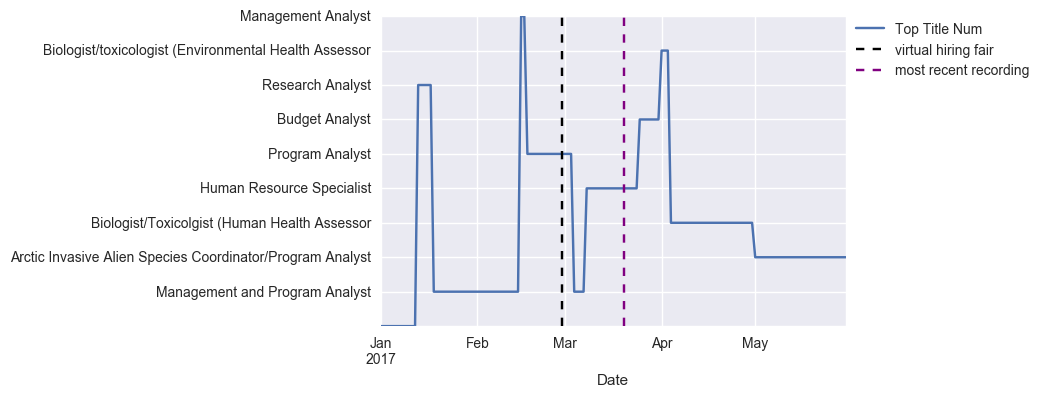

In [27]:
col='Top Title'
TA=list(df_time.loc[df_time[col].str.len()>0,col].value_counts().index)
TAdic={};
for x in range(1,len(TA)+1):
    TAdic[TA[x-1]]=x
df_time['%s Num'%col]=0
df_time['%s Num'%col]=df_time[col].map(TAdic)
df_time['%s Num'%col].fillna(0,inplace=True)
df_time.plot('Date','%s Num'%col)
LABELS=['']+TA;
plt.yticks(range(0,len(TA)+1), LABELS);
plt.axvline(pd.Timestamp('20170228'),color='black',linestyle='--',label='virtual hiring fair');
plt.axvline(pd.Timestamp('20'+date),color='purple',linestyle='--',label='most recent recording');
plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);

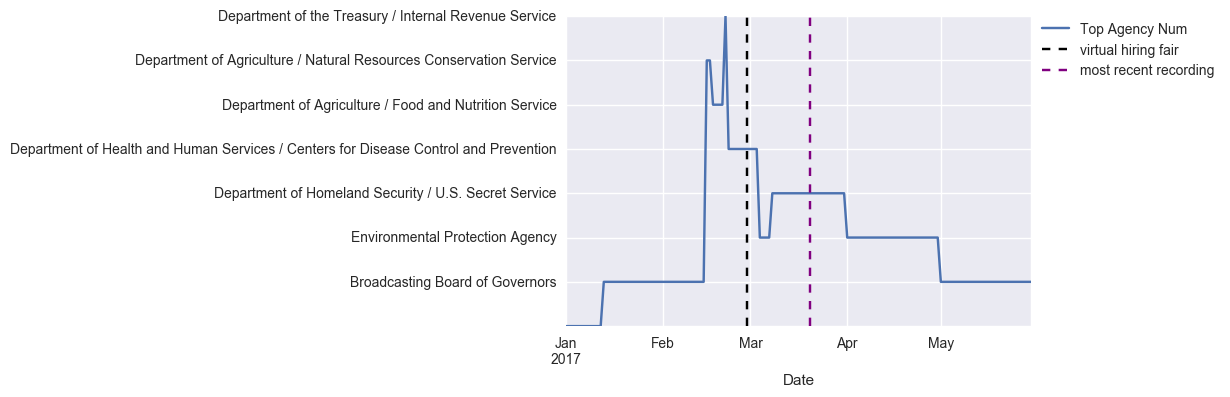

In [28]:
col='Top Agency'
TA=list(df_time.loc[df_time[col].str.len()>0,col].value_counts().index)
TAdic={};
for x in range(1,len(TA)+1):
    TAdic[TA[x-1]]=x
df_time['%s Num'%col]=0
df_time['%s Num'%col]=df_time[col].map(TAdic)
df_time['%s Num'%col].fillna(0,inplace=True)
df_time.plot('Date','%s Num'%col)
LABELS=['']+TA;
plt.yticks(range(0,len(TA)+1), LABELS);
plt.axvline(pd.Timestamp('20170228'),color='black',linestyle='--',label='virtual hiring fair');
plt.axvline(pd.Timestamp('20'+date),color='purple',linestyle='--',label='most recent recording');
plt.legend(bbox_to_anchor=(1.01, 1),loc=2,borderaxespad=0.);

How about how long a posting is scheduled to be available? Postings that are up for only a few days may already have a finalist in mind. On the other hand, postings that are open for a very long time tend to be removed before the closing date (not shown in this notebook).

In [29]:
df2['Opening Length']=pd.to_datetime(df2.loc[:,'Closing Date'],'%Y %m %d')-pd.to_datetime(df2.loc[:,'Opening Date'],'%Y %m %d')

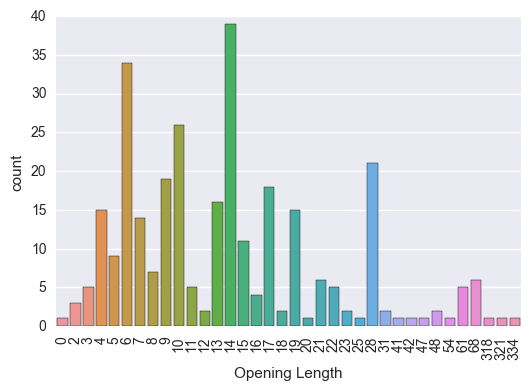

In [30]:
sns.countplot(df2['Opening Length'].dt.days);
plt.xticks(rotation=90);